In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings("ignore")

# Seasonal - Rainfall in Pakistan

Pakistan faces flood and drought more often than anyone can believe in different parts of the country year after year and the cycle seems to continue infinitely. I've created this dataset to find out if there is anything we can learn from hisotry and if we can co-relate in with global weather patterns and climate change.

The dataset contains 116 yeas of rainfall data in millimeters. The granularity is per month average rainfall.



In [2]:
rain = pd.read_csv('Rainfall_1901_2016_PAK.csv')
rain.columns = ['Rainfall - (MM)', 'Year', 'Month']

In [3]:
rain.head()

,Rainfall - (MM),Year,Month
0,40.4258,1901,January
1,12.3022,1901,February
2,25.5119,1901,March
3,14.2942,1901,April
4,38.3046,1901,May


In [4]:
rain.shape

(1392, 3)

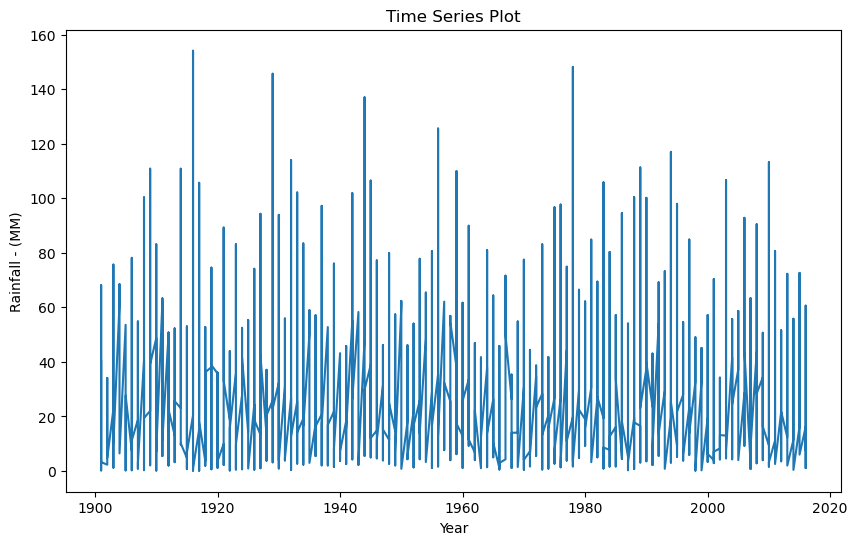

In [5]:
# plot the time series
plt.figure(figsize = (10, 6))
plt.plot(rain['Year'], rain['Rainfall - (MM)'])
plt.xlabel('Year')
plt.ylabel('Rainfall - (MM)')
plt.title('Time Series Plot')
plt.show()

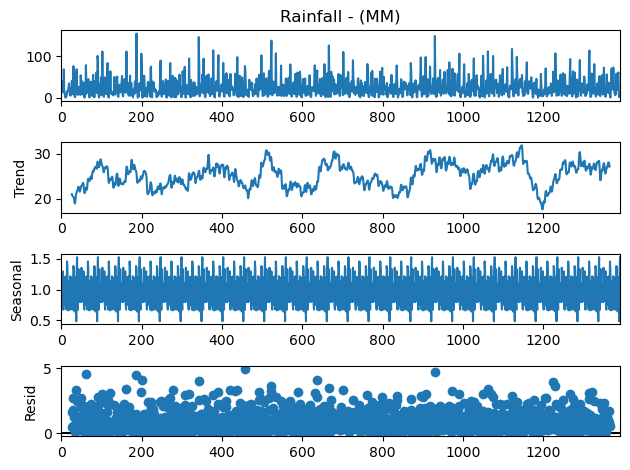

In [6]:
decomp = seasonal_decompose(rain['Rainfall - (MM)'], period=52, model='multiplicative')
decomp.plot()
plt.show()

### Stationary check  

In [7]:

from statsmodels.tsa.stattools import adfuller


# perform the ADF test on the 'Rainfall - (MM)' column
result = adfuller(rain['Rainfall - (MM)'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
print()
if result[1] < 0.05:
    print("Data is stationary")
else:
    print('Data is NOT stationary')


ADF Statistic: -6.695889
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568

Data is stationary


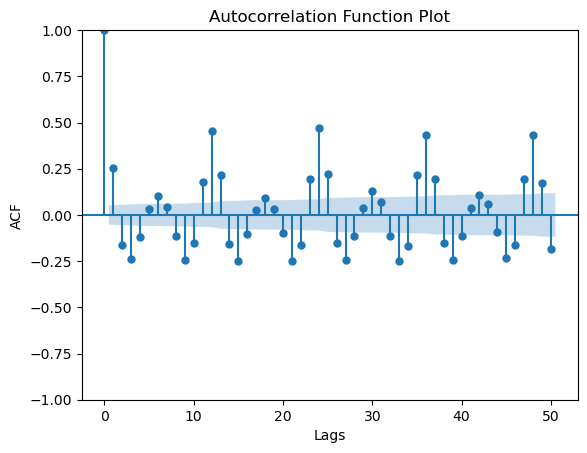

In [8]:
# plot the ACF
plot_acf(rain['Rainfall - (MM)'], lags=50)
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.title('Autocorrelation Function Plot')
plt.show()

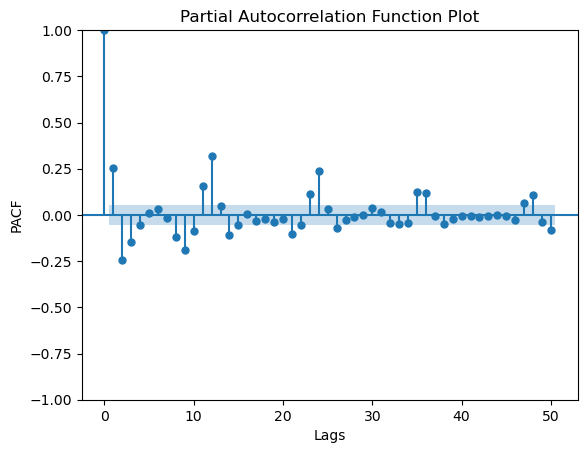

In [9]:
# plot the PACF
plot_pacf(rain['Rainfall - (MM)'], lags=50)
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.title('Partial Autocorrelation Function Plot')
plt.show()

In [10]:
# EACF

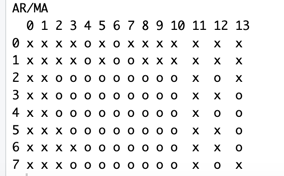

SMAPE: 58.820306775442106
Mean Squared Error: 353.2582469988269


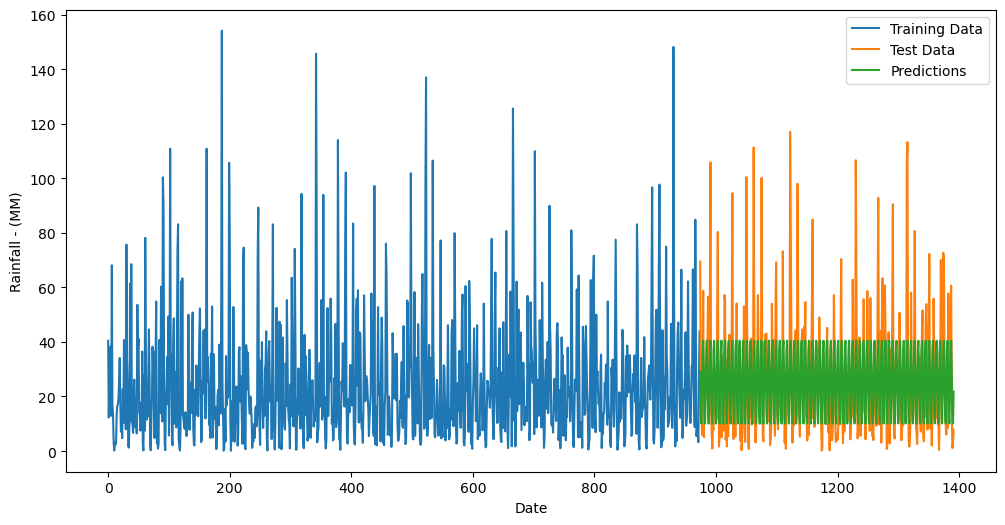

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.metrics import smape
from sklearn.metrics import mean_squared_error
import pmdarima as pm

# Load the data

rain['Date'] = [str(x) + '-' + y for x, y in zip(rain['Year'], rain['Month'])]
rain['Date'] = pd.to_datetime(rain['Date'])
rain_data = rain['Rainfall - (MM)']

# Split the data into training and test sets (80% train, 20% test)
train_data, test_data = rain_data[:int(0.7 * len(rain_data))], rain_data[int(0.7 * len(rain_data)):]



# Find the optimal order for the ARIMA model
#model = pm.auto_arima(train_data, seasonal=True, stepwise=True,
#                      suppress_warnings=True, trace=True,
#                      error_action='ignore', information_criterion='aic')
# Fit the ARIMA model
arima_model = ARIMA(train_data, order=(2,0,2)).fit()

# Make predictions
predictions = arima_model.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

# Evaluate the model
smape_value = smape(test_data, predictions)
mse_value = mean_squared_error(test_data, predictions)
print('SMAPE:', smape_value)
print('Mean Squared Error:', mse_value)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data')
plt.plot(predictions, label='Predictions')
plt.xlabel('Date')
plt.ylabel('Rainfall - (MM)')
plt.legend()
plt.show()


## Ljung-Box test

In [12]:
from statsmodels.stats.diagnostic import acorr_ljungbox

result = acorr_ljungbox(arima_model.resid, lags=[6, 12, 18], boxpierce=False)
result

,lb_stat,lb_pvalue
6,63.468949,8.856839e-12
12,133.388962,1.286813e-22
18,205.401285,8.309676e-34


In [13]:
for p in result['lb_pvalue']:
    if p < 0.05:
        print(True)

True
True
True


## Let's take log of the data

In [14]:
rain['LogReturns'] = np.log(rain['Rainfall - (MM)'] / rain['Rainfall - (MM)'].shift(1))
rain.dropna(axis = 0, inplace = True)
rain.head()

,Rainfall - (MM),Year,Month,Date,LogReturns
1,12.3022,1901,February,1901-02-01,-1.189690
2,25.5119,1901,March,1901-03-01,0.729367
3,14.2942,1901,April,1901-04-01,-0.579291
4,38.3046,1901,May,1901-05-01,0.985716
5,12.8813,1901,June,1901-06-01,-1.089793


## Check if log data is stationary

In [15]:

from statsmodels.tsa.stattools import adfuller


# perform the ADF test on the 'Rainfall - (MM)' column
result = adfuller(rain['LogReturns'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
print()
if result[1] < 0.05:
    print("Data is stationary")
else:
    print('Data is NOT stationary')


ADF Statistic: -16.160590
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568

Data is stationary


## EACF of log data

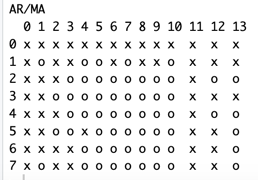

# Garch Model

In [16]:
rain.head()

,Rainfall - (MM),Year,Month,Date,LogReturns
1,12.3022,1901,February,1901-02-01,-1.189690
2,25.5119,1901,March,1901-03-01,0.729367
3,14.2942,1901,April,1901-04-01,-0.579291
4,38.3046,1901,May,1901-05-01,0.985716
5,12.8813,1901,June,1901-06-01,-1.089793


Order:  (2, 0, 2)
Iteration:      1,   Func. Count:      6,   Neg. LLF: 4466.8349575535485
Iteration:      2,   Func. Count:     12,   Neg. LLF: 4449.666184722271
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4586.578929053041
Iteration:      4,   Func. Count:     24,   Neg. LLF: 4484.324705477327
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4437.147035200262
Iteration:      6,   Func. Count:     35,   Neg. LLF: 4436.960310610535
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4436.43671325871
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4433.255184972109
Iteration:      9,   Func. Count:     50,   Neg. LLF: 4426.6400017295055
Iteration:     10,   Func. Count:     55,   Neg. LLF: 4419.588394914033
Iteration:     11,   Func. Count:     60,   Neg. LLF: 4404.753788699176
Iteration:     12,   Func. Count:     65,   Neg. LLF: 4390.319980025896
Iteration:     13,   Func. Count:     70,   Neg. LLF: 4391.393631631336
Iteration:     14,   Func. Count:     76,   N

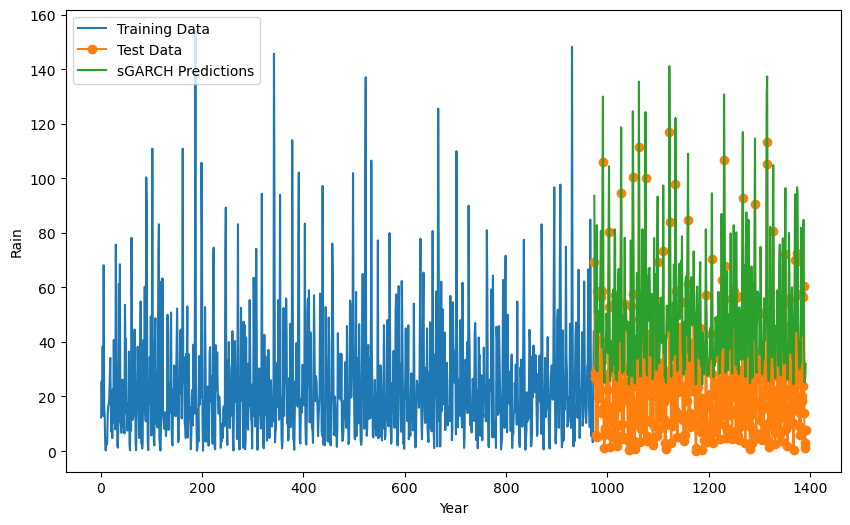

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [17]:
from arch import arch_model

# Split the dataset into training and testing sets

train_frac = 0.7
train_size = int(len(rain) * train_frac)
train_data, test_data = rain.iloc[:train_size], rain.iloc[train_size:]

# Determine the ARIMA order using auto_arima
#arima_order = pm.auto_arima(train_data['Rainfall - (MM)'], suppress_warnings=True).order
arima_order = (2, 0, 2)
print('Order: ', arima_order)
# Fit the GARCH models
# ['GARCH', 'ARCH', 'EGARCH', 'FIGARCH', 'APARCH', 'HARCH', 'FIGARCH']
models = {
    'sGARCH': arch_model(train_data['Rainfall - (MM)'], vol='Garch', p=arima_order[0], q=arima_order[1]),
    #'ARCH': arch_model(train_data['diff'], vol='ARCH', p=arima_order[0], q=arima_order[1]),
    #'GJR-GARCH': arch_model(train_data['diff'], vol='Garch', p=arima_order[0], q=arima_order[1], o=1)
}

results = {}
predictions = {}
residuals = {}

for name, model in models.items():
    results[name] = model.fit()
    #print(len(test_data['diff']))
    forecasts = results[name].forecast(horizon=len(test_data['Rainfall - (MM)']))
    predictions[name] = forecasts.mean['h.001'].cumsum().iloc[-1] + test_data['Rainfall - (MM)']
    residuals[name] = test_data['Rainfall - (MM)'] - predictions[name]

# Print the results
for name, result in results.items():
    print(f"{name} Model:")
    print(result.summary())
    print()

# Plot the training data, test data, and predictions
plt.figure(figsize=(10, 6))
plt.plot(train_data['Rainfall - (MM)'], label='Training Data')
plt.plot(test_data['Rainfall - (MM)'], label='Test Data', marker = 'o')

for name, pred in predictions.items():
    plt.plot(test_data.index, pred, label=f'{name} Predictions')

plt.xlabel('Year')
plt.ylabel('Rain')
plt.legend()
plt.show()

# Plot the residuals
plt.figure(figsize=(10, 6))
#for name, residual in residuals.items():
#    plt.plot(test_data.index, residual, label=f'{name} Residuals')
    #sns.histplot(residual, label=f'{name} Residuals', kde=True, alpha=0.5)

#plt.xlabel('Year')
#plt.ylabel('Residuals')
#plt.legend()
#plt.show()


## Garch on Log

Order:  (2, 1, 3)
Iteration:      1,   Func. Count:      7,   Neg. LLF: 3934.9548684945203
Iteration:      2,   Func. Count:     16,   Neg. LLF: 2902903.921929838
Iteration:      3,   Func. Count:     24,   Neg. LLF: 1837.8011241124238
Iteration:      4,   Func. Count:     33,   Neg. LLF: 1628.4931512099042
Iteration:      5,   Func. Count:     40,   Neg. LLF: 1624.565235522725
Iteration:      6,   Func. Count:     47,   Neg. LLF: 1620.6196637430708
Iteration:      7,   Func. Count:     53,   Neg. LLF: 1620.6196422956068
Iteration:      8,   Func. Count:     59,   Neg. LLF: 1620.6196388156513
Iteration:      9,   Func. Count:     65,   Neg. LLF: 1620.619637834212
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1620.619637834212
            Iterations: 9
            Function evaluations: 65
            Gradient evaluations: 9
sGARCH Model:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:             L

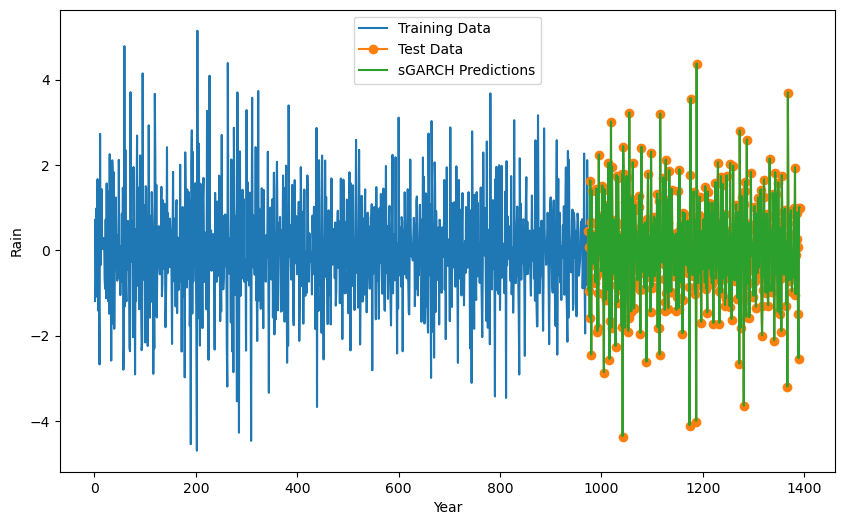

In [18]:
from arch import arch_model

# Split the dataset into training and testing sets

train_frac = 0.7
train_size = int(len(rain) * train_frac)
train_data, test_data = rain.iloc[:train_size], rain.iloc[train_size:]

# Determine the ARIMA order using auto_arima
#arima_order = pm.auto_arima(train_data['LogReturns'], suppress_warnings=True).order
arima_order = (2, 1, 3)
print('Order: ', arima_order)
# Fit the GARCH models
# ['GARCH', 'ARCH', 'EGARCH', 'FIGARCH', 'APARCH', 'HARCH', 'FIGARCH']
models = {
    'sGARCH': arch_model(train_data['LogReturns'], vol='Garch', p=arima_order[0], q=arima_order[1]),
    #'ARCH': arch_model(train_data['diff'], vol='ARCH', p=arima_order[0], q=arima_order[1]),
    #'GJR-GARCH': arch_model(train_data['diff'], vol='Garch', p=arima_order[0], q=arima_order[1], o=1)
}

results = {}
predictions = {}
residuals = {}

for name, model in models.items():
    results[name] = model.fit()
    #print(len(test_data['diff']))
    forecasts = results[name].forecast(horizon=len(test_data['LogReturns']))
    predictions[name] = forecasts.mean['h.001'].cumsum().iloc[-1] + test_data['LogReturns']
    residuals[name] = test_data['LogReturns'] - predictions[name]

# Print the results
for name, result in results.items():
    print(f"{name} Model:")
    print(result.summary())
    print()

# Plot the training data, test data, and predictions
plt.figure(figsize=(10, 6))
plt.plot(train_data['LogReturns'], label='Training Data')
plt.plot(test_data['LogReturns'], label='Test Data', marker = 'o')

for name, pred in predictions.items():
    plt.plot(test_data.index, pred, label=f'{name} Predictions')

plt.xlabel('Year')
plt.ylabel('Rain')
plt.legend()
plt.show()

# Plot the residuals
#plt.figure(figsize=(10, 6))
#for name, residual in residuals.items():
#    plt.plot(test_data.index, residual, label=f'{name} Residuals')
#    sns.histplot(residual, label=f'{name} Residuals', kde=True, alpha=0.5)

#plt.xlabel('Year')
#plt.ylabel('Residuals')
#plt.legend()
#plt.show()


In [19]:
from statsmodels.stats.diagnostic import acorr_ljungbox

result = acorr_ljungbox(residuals['sGARCH'], lags=[6, 12, 18], boxpierce=False)
result

,lb_stat,lb_pvalue
6,1.690790,0.945830
12,5.469547,0.940433
18,9.383338,0.950190


In [20]:
for p in result['lb_pvalue']:
    if p < 0.05:
        print(True)
    else:
        print(False)

False
False
False


# Non Seasonal - Pakistan's GDP


This is the dataset of Pakistan's GDP from 1960-2022. The dataset includes 4 columns and 60 rows.

In [21]:
gdp = pd.read_csv('Pakistan_GDP.csv')

In [22]:
gdp.head()

,Indicator Name,Indicator Code,Year,GDP
0,GDP (current US$),NY.GDP.MKTP.CD,1965,5929231415
1,GDP (current US$),NY.GDP.MKTP.CD,1966,6561108778
2,GDP (current US$),NY.GDP.MKTP.CD,1967,7464510710
3,GDP (current US$),NY.GDP.MKTP.CD,1968,8041999160
4,GDP (current US$),NY.GDP.MKTP.CD,1969,8683116338


In [23]:
gdp.shape

(58, 4)

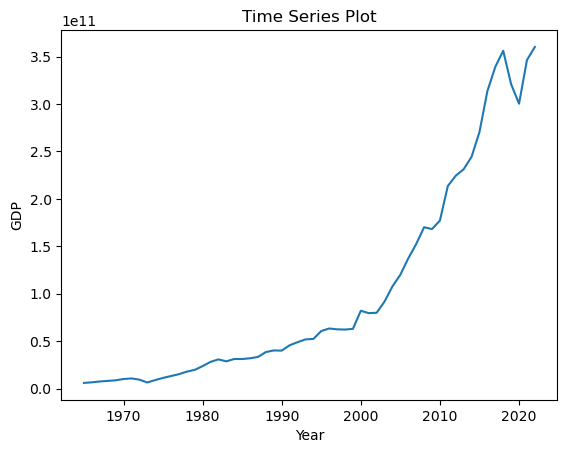

In [24]:
# plot the time series
plt.plot(gdp['Year'], gdp['GDP'])
plt.xlabel('Year')
plt.ylabel('GDP')
plt.title('Time Series Plot')
plt.show()

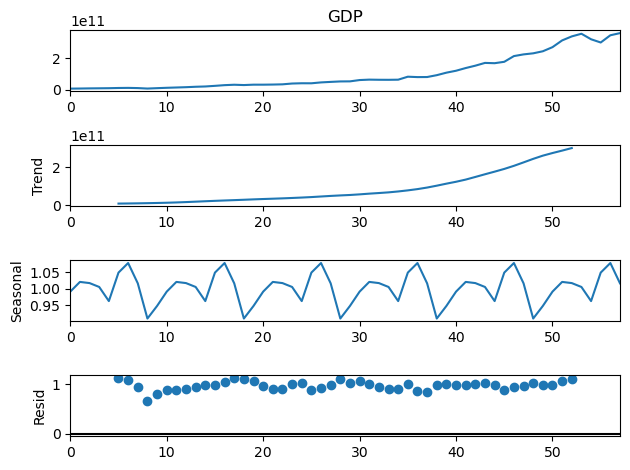

In [25]:
decomp = seasonal_decompose(gdp['GDP'], period=10, model='multiplicative')
decomp.plot()
plt.show()

### Stationary check

In [26]:

from statsmodels.tsa.stattools import adfuller


# perform the ADF test on the 'GDP' column
result = adfuller(gdp['GDP'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
print()
if result[1] < 0.05:
    print("Data is stationary")
else:
    print('Data is NOT stationary')


ADF Statistic: -1.967425
p-value: 0.301036
Critical Values:
	1%: -3.581
	5%: -2.927
	10%: -2.602

Data is NOT stationary


## First difference

In [27]:
# Taking the first difference

# make the data stationary by taking the first difference
gdp['diff'] = gdp['GDP'].diff()
gdp = gdp[~gdp['diff'].isnull()]
# perform the ADF test on the differenced data
result = adfuller(gdp['diff'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[1] < 0.05:
    print("Data is stationary")
else:
    print('Data is NOT stationary')

ADF Statistic: -1.017002
p-value: 0.747013
Critical Values:
	1%: -3.578
	5%: -2.925
	10%: -2.601
Data is NOT stationary


## Second difference

In [28]:
# Taking the second difference

# make the data stationary by taking the second difference
gdp['diff'] = gdp['GDP'].diff().diff()
gdp = gdp[~gdp['diff'].isnull()]
# perform the ADF test on the differenced data
result = adfuller(gdp['diff'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[1] < 0.05:
    print("Data is stationary")
else:
    print('Data is NOT stationary')

ADF Statistic: -2.716216
p-value: 0.071274
Critical Values:
	1%: -3.581
	5%: -2.927
	10%: -2.602
Data is NOT stationary


## Third difference

In [29]:
# Taking the third difference

# make the data stationary by taking the third difference
gdp['diff'] = gdp['GDP'].diff().diff().diff()
gdp = gdp[~gdp['diff'].isnull()]
# perform the ADF test on the differenced data
result = adfuller(gdp['diff'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[1] < 0.05:
    print("Data is stationary")
else:
    print('Data is NOT stationary')

ADF Statistic: -3.621317
p-value: 0.005366
Critical Values:
	1%: -3.606
	5%: -2.937
	10%: -2.607
Data is stationary


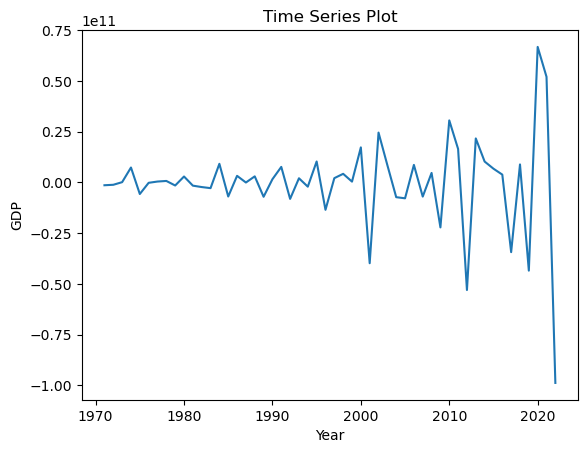

In [30]:
# plot the time series
plt.plot(gdp['Year'], gdp['diff'])
plt.xlabel('Year')
plt.ylabel('GDP')
plt.title('Time Series Plot')
plt.show()

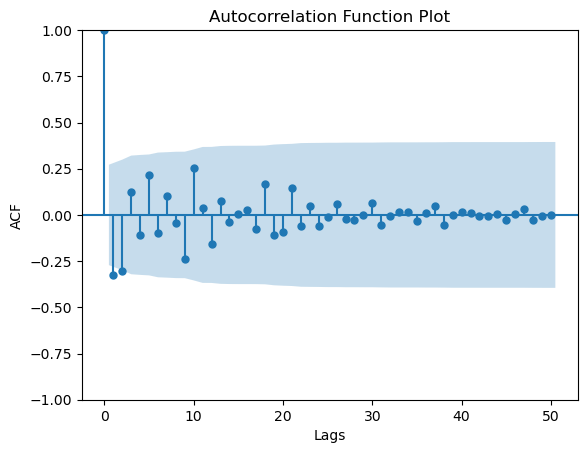

In [31]:
# plot the ACF
plot_acf(gdp['diff'], lags=50)
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.title('Autocorrelation Function Plot')
plt.show()

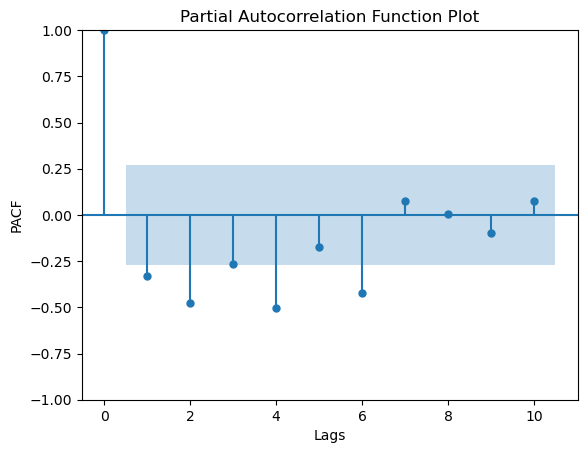

In [32]:
# plot the PACF
plot_pacf(gdp['diff'], lags=10)
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.title('Partial Autocorrelation Function Plot')
plt.show()

In [33]:
# EACF

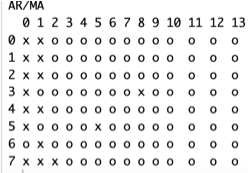

In [34]:
gdp = gdp.reset_index(drop = True)

## (3, 3, 1)

SMAPE: 145.9976495122794
Mean Squared Error: 4.855340036729699e+21


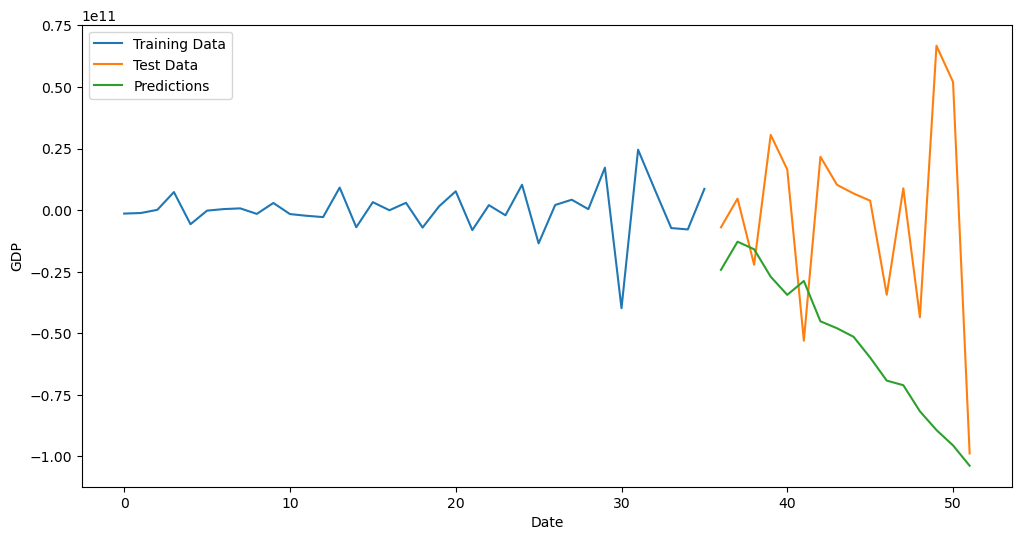

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.metrics import smape
from sklearn.metrics import mean_squared_error
import pmdarima as pm

# Load the data

#gdp['Date'] = pd.to_datetime(gdp['Year'])
gdp_data = gdp['diff']

# Split the data into training and test sets (80% train, 20% test)
train_data, test_data = gdp_data[:int(0.7 * len(gdp_data))], gdp_data[int(0.7 * len(gdp_data)):]


# Find the optimal order for the ARIMA model
#model = pm.auto_arima(train_data, seasonal=False, stepwise=True,
#                      suppress_warnings=True, trace=True,
#                      error_action='ignore', information_criterion='aic')
# Fit the ARIMA(7, 9) model
arima_model = ARIMA(train_data, order=(3, 3, 1)).fit()

# Make predictions
predictions = arima_model.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

# Evaluate the model
smape_value = smape(test_data, predictions)
mse_value = mean_squared_error(test_data, predictions)
print('SMAPE:', smape_value)
print('Mean Squared Error:', mse_value)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data')
plt.plot(predictions, label='Predictions')
plt.xlabel('Date')
plt.ylabel('GDP')
plt.legend()
plt.show()


## (3, 3, 2)

SMAPE: 163.91262047588242
Mean Squared Error: 1.7144821882545323e+21


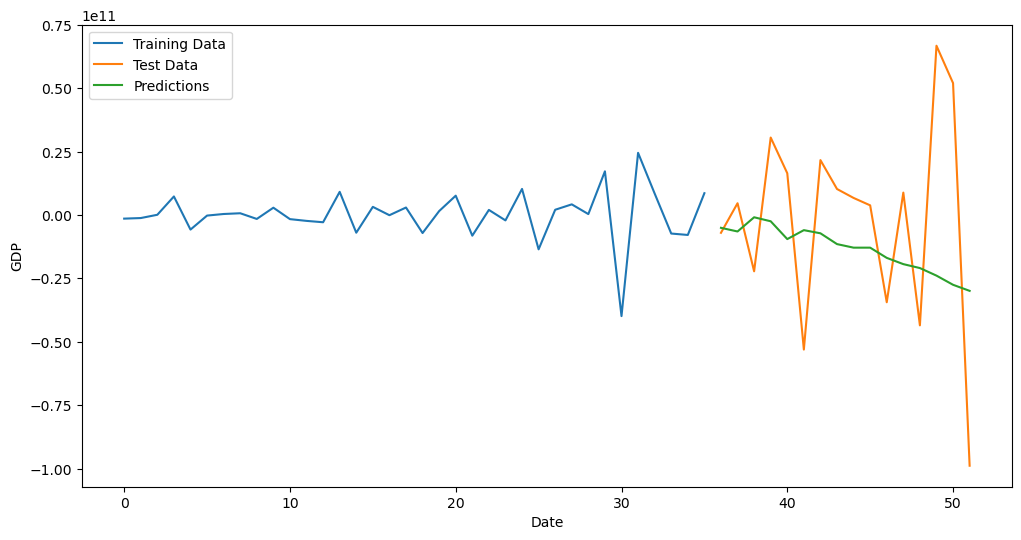

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.metrics import smape
from sklearn.metrics import mean_squared_error
import pmdarima as pm

# Load the data

#gdp['Date'] = pd.to_datetime(gdp['Year'])
gdp_data = gdp['diff']

# Split the data into training and test sets (80% train, 20% test)
train_data, test_data = gdp_data[:int(0.7 * len(gdp_data))], gdp_data[int(0.7 * len(gdp_data)):]


# Find the optimal order for the ARIMA model
#model = pm.auto_arima(train_data, seasonal=False, stepwise=True,
#                      suppress_warnings=True, trace=True,
#                      error_action='ignore', information_criterion='aic')
# Fit the ARIMA(7, 9) model
arima_model = ARIMA(train_data, order=(3, 3, 2)).fit()

# Make predictions
predictions = arima_model.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

# Evaluate the model
smape_value = smape(test_data, predictions)
mse_value = mean_squared_error(test_data, predictions)
print('SMAPE:', smape_value)
print('Mean Squared Error:', mse_value)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data')
plt.plot(predictions, label='Predictions')
plt.xlabel('Date')
plt.ylabel('GDP')
plt.legend()
plt.show()


## (4, 3, 2)


SMAPE: 144.73732962185093
Mean Squared Error: 1.960061370377936e+21


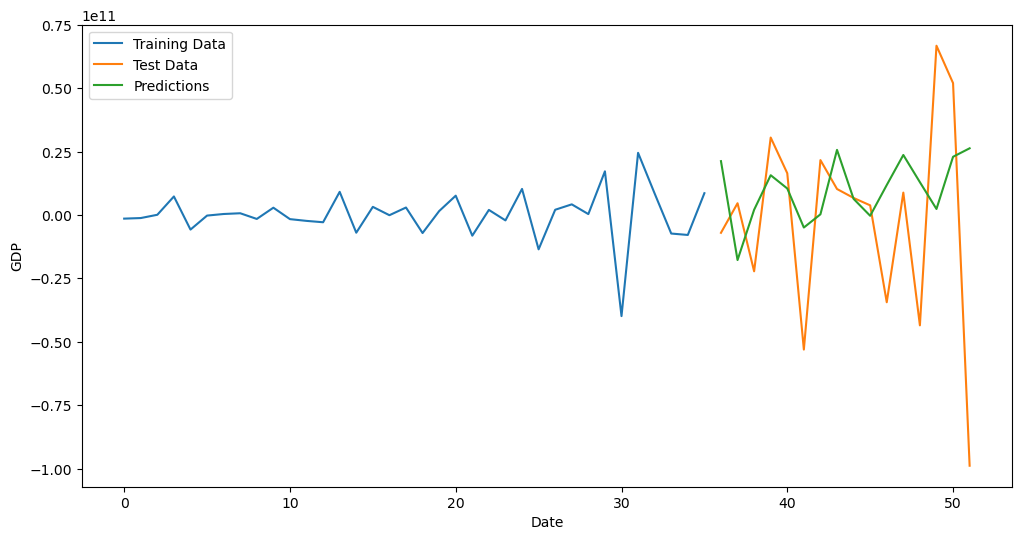

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.metrics import smape
from sklearn.metrics import mean_squared_error
import pmdarima as pm

# Load the data

#gdp['Date'] = pd.to_datetime(gdp['Year'])
gdp_data = gdp['diff']

# Split the data into training and test sets (80% train, 20% test)
train_data, test_data = gdp_data[:int(0.7 * len(gdp_data))], gdp_data[int(0.7 * len(gdp_data)):]


# Find the optimal order for the ARIMA model
#model = pm.auto_arima(train_data, seasonal=False, stepwise=True,
#                      suppress_warnings=True, trace=True,
#                      error_action='ignore', information_criterion='aic')
# Fit the ARIMA(7, 9) model
arima_model = ARIMA(train_data, order=(4, 3, 2)).fit()

# Make predictions
predictions = arima_model.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

# Evaluate the model
smape_value = smape(test_data, predictions)
mse_value = mean_squared_error(test_data, predictions)
print('SMAPE:', smape_value)
print('Mean Squared Error:', mse_value)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data')
plt.plot(predictions, label='Predictions')
plt.xlabel('Date')
plt.ylabel('GDP')
plt.legend()
plt.show()


## (5, 3, 1)

SMAPE: 144.79918906970363
Mean Squared Error: 2.3850433290660154e+21


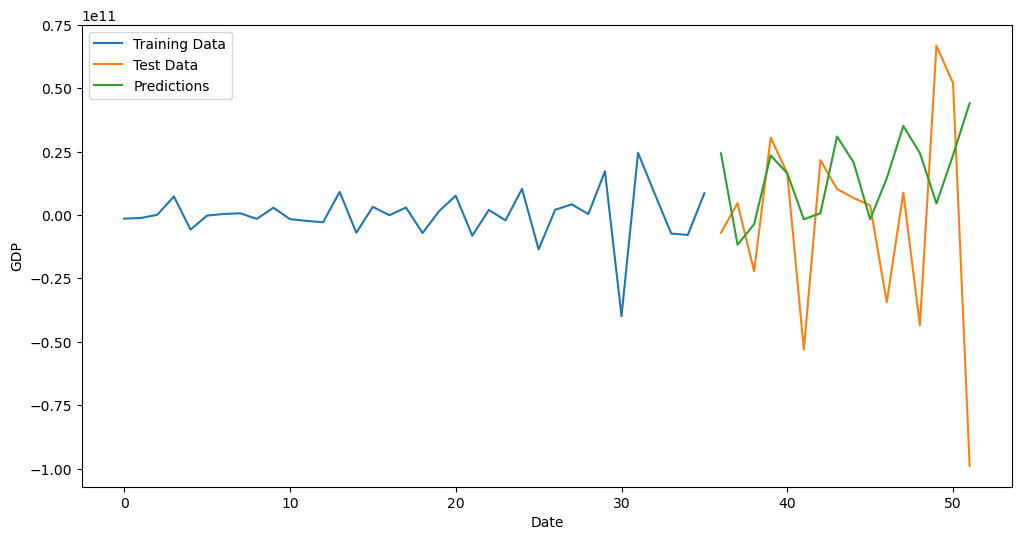

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.metrics import smape
from sklearn.metrics import mean_squared_error
import pmdarima as pm

# Load the data

#gdp['Date'] = pd.to_datetime(gdp['Year'])
gdp_data = gdp['diff']

# Split the data into training and test sets (80% train, 20% test)
train_data, test_data = gdp_data[:int(0.7 * len(gdp_data))], gdp_data[int(0.7 * len(gdp_data)):]


# Find the optimal order for the ARIMA model
#model = pm.auto_arima(train_data, seasonal=False, stepwise=True,
#                      suppress_warnings=True, trace=True,
#                      error_action='ignore', information_criterion='aic')
# Fit the ARIMA(7, 9) model
arima_model = ARIMA(train_data, order=(5, 3, 1)).fit()

# Make predictions
predictions = arima_model.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

# Evaluate the model
smape_value = smape(test_data, predictions)
mse_value = mean_squared_error(test_data, predictions)
print('SMAPE:', smape_value)
print('Mean Squared Error:', mse_value)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data')
plt.plot(predictions, label='Predictions')
plt.xlabel('Date')
plt.ylabel('GDP')
plt.legend()
plt.show()


# Garch Model

In [39]:
gdp.head()

,Indicator Name,Indicator Code,Year,GDP,diff
0,GDP (current US$),NY.GDP.MKTP.CD,1971,10665896682,-1.409282e+09
1,GDP (current US$),NY.GDP.MKTP.CD,1972,9415016360,-1.183262e+09
2,GDP (current US$),NY.GDP.MKTP.CD,1973,6383429490,1.085610e+08
3,GDP (current US$),NY.GDP.MKTP.CD,1974,8899191919,7.328056e+09
4,GDP (current US$),NY.GDP.MKTP.CD,1975,11230606061,-5.731698e+09


Iteration:      1,   Func. Count:     10,   Neg. LLF: 878.5302964250159
Iteration:      2,   Func. Count:     20,   Neg. LLF: 868.0971938740887
Iteration:      3,   Func. Count:     29,   Neg. LLF: 867.5218698477476
Iteration:      4,   Func. Count:     38,   Neg. LLF: 867.2527729828754
Iteration:      5,   Func. Count:     47,   Neg. LLF: 867.1560084060899
Iteration:      6,   Func. Count:     56,   Neg. LLF: 867.1069818397103
Iteration:      7,   Func. Count:     65,   Neg. LLF: 867.1046847414294
Iteration:      8,   Func. Count:     74,   Neg. LLF: 867.104664855307
Iteration:      9,   Func. Count:     82,   Neg. LLF: 867.1046648305627
Optimization terminated successfully    (Exit mode 0)
            Current function value: 867.104664855307
            Iterations: 9
            Function evaluations: 82
            Gradient evaluations: 9
sGARCH Model:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   diff   R-squared:    

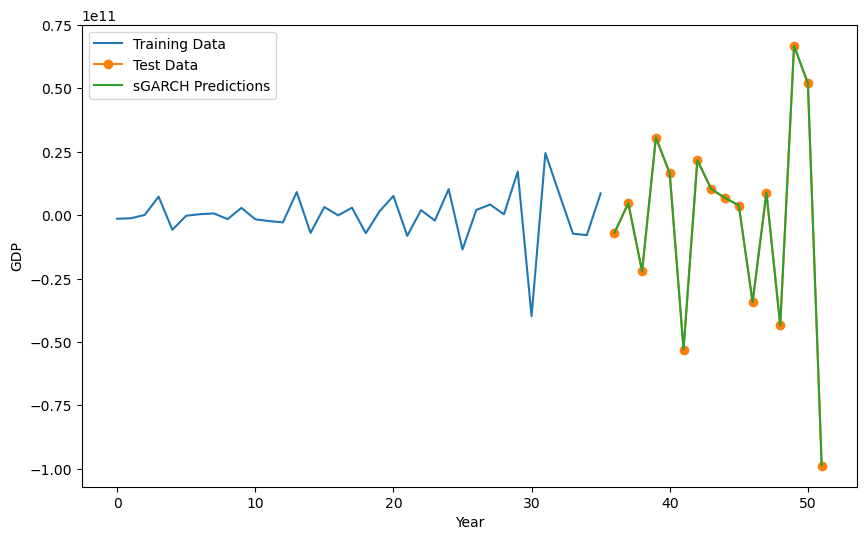

In [40]:
from arch import arch_model

# Split the dataset into training and testing sets

train_frac = 0.7
train_size = int(len(gdp) * train_frac)
train_data, test_data = gdp.iloc[:train_size], gdp.iloc[train_size:]

# Determine the ARIMA order using auto_arima
#arima_order = pm.auto_arima(train_data['diff'], suppress_warnings=True).order
arima_order = (3, 3, 1)
# Fit the GARCH models
# ['GARCH', 'ARCH', 'EGARCH', 'FIGARCH', 'APARCH', 'HARCH', 'FIGARCH']
models = {
    'sGARCH': arch_model(train_data['diff'], vol='Garch', p=arima_order[0], q=arima_order[1]),
    #'ARCH': arch_model(train_data['diff'], vol='ARCH', p=arima_order[0], q=arima_order[1]),
    #'GJR-GARCH': arch_model(train_data['diff'], vol='Garch', p=arima_order[0], q=arima_order[1], o=1)
}

results = {}
predictions = {}
residuals = {}

for name, model in models.items():
    results[name] = model.fit()
    #print(len(test_data['diff']))
    forecasts = results[name].forecast(horizon=len(test_data['diff']))
    predictions[name] = forecasts.mean['h.01'].cumsum().iloc[-1] + test_data['diff']
    residuals[name] = test_data['diff'] - predictions[name]

# Print the results
for name, result in results.items():
    print(f"{name} Model:")
    print(result.summary())
    print()

# Plot the training data, test data, and predictions
plt.figure(figsize=(10, 6))
plt.plot(train_data['diff'], label='Training Data')
plt.plot(test_data['diff'], label='Test Data', marker = 'o')

for name, pred in predictions.items():
    plt.plot(test_data.index, pred, label=f'{name} Predictions')

plt.xlabel('Year')
plt.ylabel('GDP')
plt.legend()
plt.show()

# Plot the residuals
#plt.figure(figsize=(10, 6))
#for name, residual in residuals.items():
    #plt.plot(test_data.index, residual, label=f'{name} Residuals')
    #sns.histplot(residual, label=f'{name} Residuals', kde=True, alpha=0.5)

#plt.xlabel('Year')
#plt.ylabel('Residuals')
#plt.legend()
#plt.show()


In [41]:
from statsmodels.stats.diagnostic import acorr_ljungbox

result = acorr_ljungbox(residuals['sGARCH'], boxpierce=False)
result

,lb_stat,lb_pvalue
1,4.436256,0.035183
2,5.745453,0.056545
3,5.758069,0.123993


## Garch on log 

In [42]:
gdp['LogReturns'] = np.log(gdp['GDP'] / gdp['GDP'].shift(1))
gdp.dropna(axis = 0, inplace = True)
gdp.head()

,Indicator Name,Indicator Code,Year,GDP,diff,LogReturns
1,GDP (current US$),NY.GDP.MKTP.CD,1972,9415016360,-1.183262e+09,-0.124746
2,GDP (current US$),NY.GDP.MKTP.CD,1973,6383429490,1.085610e+08,-0.388600
3,GDP (current US$),NY.GDP.MKTP.CD,1974,8899191919,7.328056e+09,0.332255
4,GDP (current US$),NY.GDP.MKTP.CD,1975,11230606061,-5.731698e+09,0.232682
5,GDP (current US$),NY.GDP.MKTP.CD,1976,13168080808,-2.095911e+08,0.159153


## Stationary check on LogReturns

In [43]:
# Taking the third difference

# make the data stationary by taking the third difference
#gdp['diff'] = gdp['LogReturns'].diff().diff().diff()
#gdp = gdp[~gdp['diff'].isnull()]
# perform the ADF test on the differenced data
result = adfuller(gdp['LogReturns'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[1] < 0.05:
    print("Data is stationary")
else:
    print('Data is NOT stationary')

ADF Statistic: -8.303370
p-value: 0.000000
Critical Values:
	1%: -3.571
	5%: -2.923
	10%: -2.599
Data is stationary


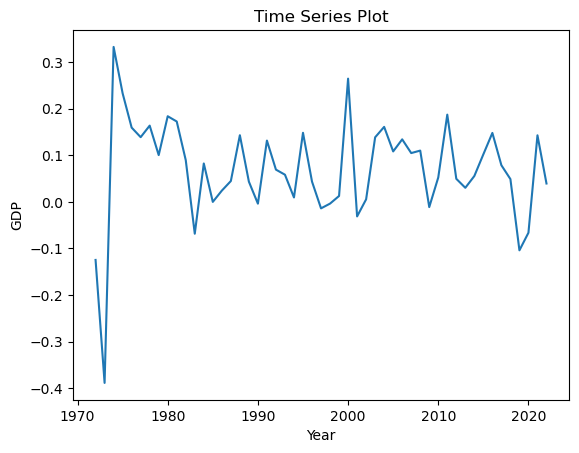

In [44]:
# plot the time series
plt.plot(gdp['Year'], gdp['LogReturns'])
plt.xlabel('Year')
plt.ylabel('GDP')
plt.title('Time Series Plot')
plt.show()

Order:  (3, 0, 2)
Iteration:      1,   Func. Count:      7,   Neg. LLF: 203.29167730705404
Iteration:      2,   Func. Count:     17,   Neg. LLF: 8.979672862142941
Iteration:      3,   Func. Count:     26,   Neg. LLF: 1243.7003378797642
Iteration:      4,   Func. Count:     33,   Neg. LLF: -6.1718790844313425
Iteration:      5,   Func. Count:     40,   Neg. LLF: -13.006047059960256
Iteration:      6,   Func. Count:     47,   Neg. LLF: -22.459028519547687
Iteration:      7,   Func. Count:     54,   Neg. LLF: -15.52412044066316
Iteration:      8,   Func. Count:     61,   Neg. LLF: -26.631782794607997
Iteration:      9,   Func. Count:     69,   Neg. LLF: -18.201046140026214
Iteration:     10,   Func. Count:     76,   Neg. LLF: -10.6419409473203
Iteration:     11,   Func. Count:     83,   Neg. LLF: -10.227322578108128
Iteration:     12,   Func. Count:     90,   Neg. LLF: -11.094573420115037
Iteration:     13,   Func. Count:     97,   Neg. LLF: -29.333843174099922
Iteration:     14,   Func. 

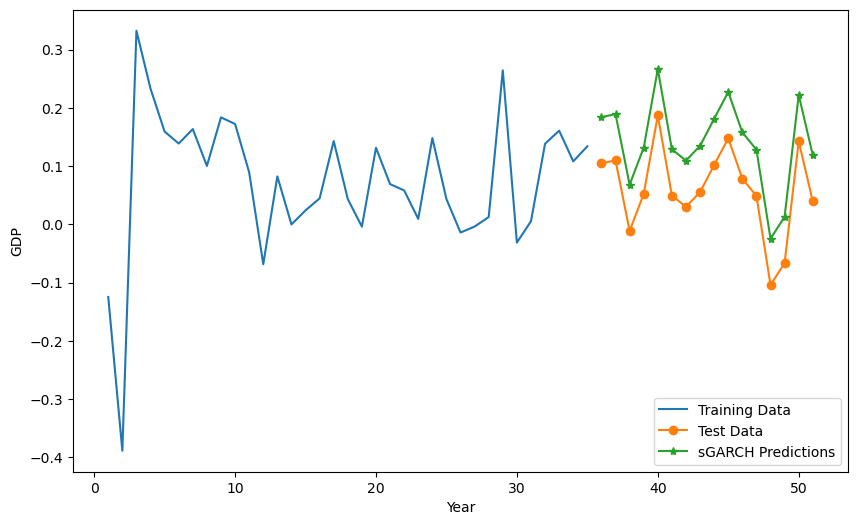

In [45]:
from arch import arch_model

# Split the dataset into training and testing sets

train_frac = 0.7
train_size = int(len(gdp) * train_frac)
train_data, test_data = gdp.iloc[:train_size], gdp.iloc[train_size:]

# Determine the ARIMA order using auto_arima
arima_order = pm.auto_arima(train_data['diff'], suppress_warnings=True).order
#arima_order = (3, 1, 2)
print('Order: ', arima_order)

# Fit the GARCH models
# ['GARCH', 'ARCH', 'EGARCH', 'FIGARCH', 'APARCH', 'HARCH', 'FIGARCH']
models = {
    'sGARCH': arch_model(train_data['LogReturns'], vol='Garch', p=arima_order[0], q=arima_order[1]),
    #'ARCH': arch_model(train_data['diff'], vol='ARCH', p=arima_order[0], q=arima_order[1]),
    #'GJR-GARCH': arch_model(train_data['diff'], vol='Garch', p=arima_order[0], q=arima_order[1], o=1)
}

results = {}
predictions = {}
residuals = {}

for name, model in models.items():
    results[name] = model.fit()
    #print(len(test_data['diff']))
    forecasts = results[name].forecast(horizon=len(test_data['diff']))
    predictions[name] = forecasts.mean['h.01'].cumsum().iloc[-1] + test_data['LogReturns']
    residuals[name] = test_data['LogReturns'] - predictions[name]

# Print the results
for name, result in results.items():
    print(f"{name} Model:")
    print(result.summary())
    print()

# Plot the training data, test data, and predictions
plt.figure(figsize=(10, 6))
plt.plot(train_data['LogReturns'], label='Training Data')
plt.plot(test_data['LogReturns'], label='Test Data', marker = 'o')

for name, pred in predictions.items():
    plt.plot(test_data.index, pred, label=f'{name} Predictions', marker = '*')

plt.xlabel('Year')
plt.ylabel('GDP')
plt.legend()
plt.show()

# Plot the residuals
#plt.figure(figsize=(10, 6))
#for name, residual in residuals.items():
    #plt.plot(test_data.index, residual, label=f'{name} Residuals')
#    sns.histplot(residual, label=f'{name} Residuals', kde=True, alpha=0.5)

#plt.xlabel('Year')
#plt.ylabel('Residuals')
#plt.legend()
#plt.show()


In [46]:
from statsmodels.stats.diagnostic import acorr_ljungbox

result = acorr_ljungbox(residuals['sGARCH'], boxpierce=False)
result

,lb_stat,lb_pvalue
1,0.000000,1.000000
2,0.000000,1.000000
3,2.461538,0.482282


# Conclusion